Top Trades to Watch for AAPL Options:

Near-term Options:
  Expiration: 2025-08-29
    Calls: Average strike ~$166.91, Open Interest: 274731, Bid/Ask: $14.47/$15.05.
    Puts: Average strike ~$160.17, Open Interest: 204523, Bid/Ask: $18.93/$19.67.
  Expiration: 2025-09-05
    Calls: Average strike ~$168.48, Open Interest: 80960, Bid/Ask: $13.93/$14.28.
    Puts: Average strike ~$162.26, Open Interest: 87318, Bid/Ask: $20.19/$20.80.
  Expiration: 2025-09-12
    Calls: Average strike ~$170.04, Open Interest: 34307, Bid/Ask: $13.51/$13.87.
    Puts: Average strike ~$161.77, Open Interest: 36543, Bid/Ask: $19.53/$20.04.
  Expiration: 2025-09-19
    Calls: Average strike ~$128.11, Open Interest: 346270, Bid/Ask: $48.62/$49.18.
    Puts: Average strike ~$125.13, Open Interest: 374632, Bid/Ask: $18.11/$18.52.
  Expiration: 2025-09-26
    Calls: Average strike ~$174.50, Open Interest: 29172, Bid/Ask: $12.56/$12.87.
    Puts: Average strike ~$169.85, Open Interest: 29733, Bid/Ask: $25.72/$26.37

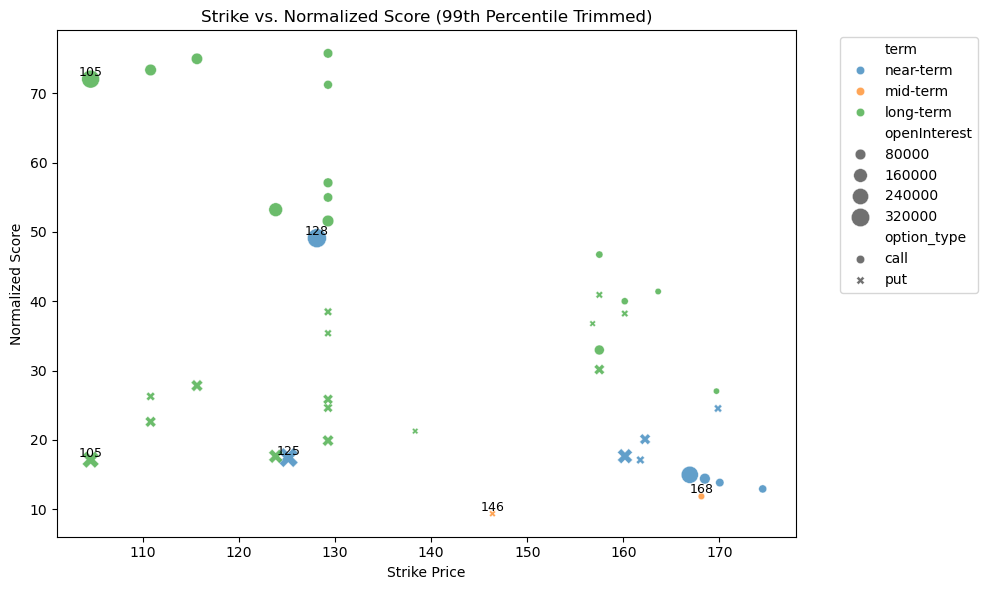

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# === Step 1: Data Collection & Aggregation ===
def get_aggregated_option_metrics(ticker_symbol="AAPL"):
    ticker = yf.Ticker(ticker_symbol)
    expirations = ticker.options
    contracts = []
    
    # Loop through each expiration date and extract calls and puts
    for exp in expirations:
        opt_chain = ticker.option_chain(exp)
        calls_df = opt_chain.calls
        puts_df = opt_chain.puts

        # Process calls
        for _, row in calls_df.iterrows():
            contract = {
                "symbol": row.get("contractSymbol", ""),
                "strikePrice": row.get("strike", None),
                "expirationDate": exp,  # using expiration string (YYYY-MM-DD)
                "bid": row.get("bid", None),
                "ask": row.get("ask", None),
                "optionType": "call",
                "volume": row.get("volume", 0),
                "openInterest": row.get("openInterest", 0),
                "premium": row.get("lastPrice", None)
            }
            contracts.append(contract)
            
        # Process puts
        for _, row in puts_df.iterrows():
            contract = {
                "symbol": row.get("contractSymbol", ""),
                "strikePrice": row.get("strike", None),
                "expirationDate": exp,
                "bid": row.get("bid", None),
                "ask": row.get("ask", None),
                "optionType": "put",
                "volume": row.get("volume", 0),
                "openInterest": row.get("openInterest", 0),
                "premium": row.get("lastPrice", None)
            }
            contracts.append(contract)
    
    df = pd.DataFrame(contracts)
    df['spread'] = df['ask'] - df['bid']
    
    # Aggregate metrics by expiration and option type
    aggregated = df.groupby(['expirationDate', 'optionType']).agg({
        'bid': 'mean',
        'ask': 'mean',
        'spread': 'mean',
        'volume': 'sum',
        'openInterest': 'sum',
        'premium': 'mean',
        'strikePrice': 'mean'
    }).reset_index()
    
    return aggregated

# === Utility: Compute Days to Expiration (DTE) and Classify Term ===
def classify_term(expiration_str):
    try:
        exp_date = datetime.strptime(expiration_str, "%Y-%m-%d")
    except Exception:
        return "unknown"
    today = datetime.today()
    dte = (exp_date - today).days
    if dte < 30:
        return "near-term"
    elif 30 <= dte <= 45:
        return "mid-term"
    else:
        return "long-term"

# === Step 2: Generate Enhanced Summary with Dynamic Final Sentiment ===
def generate_top_trades_summary(aggregated_df):
    summary_lines = []
    summary_lines.append("Top Trades to Watch for AAPL Options:")
    summary_lines.append("")
    
    # Add term classification
    aggregated_df['term'] = aggregated_df['expirationDate'].apply(classify_term)
    
    # Group by term and then by expiration for detailed listing
    for term in ["near-term", "mid-term", "long-term"]:
        term_data = aggregated_df[aggregated_df['term'] == term]
        if term_data.empty:
            continue
        summary_lines.append(f"{term.capitalize()} Options:")
        for exp in sorted(term_data['expirationDate'].unique()):
            exp_data = term_data[term_data['expirationDate'] == exp]
            summary_lines.append(f"  Expiration: {exp}")
            
            # Top Call option for this expiration
            call_data = exp_data[exp_data['optionType'] == "call"]
            if not call_data.empty:
                top_call = call_data.sort_values(by="openInterest", ascending=False).iloc[0]
                summary_lines.append(
                    f"    Calls: Average strike ~${top_call['strikePrice']:.2f}, "
                    f"Open Interest: {top_call['openInterest']:.0f}, "
                    f"Bid/Ask: ${top_call['bid']:.2f}/${top_call['ask']:.2f}."
                )
            else:
                summary_lines.append("    No call options data available.")
            
            # Top Put option for this expiration
            put_data = exp_data[exp_data['optionType'] == "put"]
            if not put_data.empty:
                top_put = put_data.sort_values(by="openInterest", ascending=False).iloc[0]
                summary_lines.append(
                    f"    Puts: Average strike ~${top_put['strikePrice']:.2f}, "
                    f"Open Interest: {top_put['openInterest']:.0f}, "
                    f"Bid/Ask: ${top_put['bid']:.2f}/${top_put['ask']:.2f}."
                )
            else:
                summary_lines.append("    No put options data available.")
        summary_lines.append("")
    
    # Overall Market Sentiment Analysis (using next 3 expirations)
    unique_exps = sorted(aggregated_df['expirationDate'].unique())
    next_3_exps = unique_exps[:3]
    total_calls_oi = aggregated_df[
        (aggregated_df['expirationDate'].isin(next_3_exps)) & (aggregated_df['optionType'] == "call")
    ]['openInterest'].sum()
    total_puts_oi = aggregated_df[
        (aggregated_df['expirationDate'].isin(next_3_exps)) & (aggregated_df['optionType'] == "put")
    ]['openInterest'].sum()
    
    summary_lines.append("Market Sentiment (Next 3 Expirations):")
    summary_lines.append(f"  Total call open interest: {total_calls_oi:.0f}")
    summary_lines.append(f"  Total put open interest: {total_puts_oi:.0f}")
    if total_calls_oi > total_puts_oi:
        sentiment = "Overall, call options dominate, indicating a bullish sentiment."
    elif total_puts_oi > total_calls_oi:
        sentiment = "Overall, put options dominate, indicating a bearish or protective sentiment."
    else:
        sentiment = "Call and put open interest are balanced, suggesting neutral sentiment."
    summary_lines.append(f"  {sentiment}")
    summary_lines.append("")
    
    # Enhanced Overall Pattern Analysis with Actionable Insights
    overall_call_strikes = aggregated_df[aggregated_df['optionType'] == "call"]['strikePrice']
    overall_put_strikes = aggregated_df[aggregated_df['optionType'] == "put"]['strikePrice']
        
    if not overall_call_strikes.empty and not overall_put_strikes.empty:
        avg_call_strike = overall_call_strikes.mean()
        avg_put_strike = overall_put_strikes.mean()
        pattern_analysis = (
            f"The average call strike is approximately ${avg_call_strike:.2f}, while the average put strike is about ${avg_put_strike:.2f}.\n"
            "This suggests that traders are positioning for a bullish move, with calls set at higher strikes to capture potential upside\n"
            "and puts used as hedges at lower levels.\n"
            "These key pivot points imply that the stock is expected to trade within a defined range, with resistance near the call levels\n"
            "and support around the put levels.\n"
            "Such insights can help in identifying entry, exit, or hedging opportunities."
        )
        summary_lines.append("Overall Pattern Analysis:")
        summary_lines.append(f"  {pattern_analysis}")
    else:
        summary_lines.append("Overall Pattern Analysis: Insufficient data for further insights.")

    
    # Dynamic Final Sentiment per term based on aggregated open interest
    final_sentiments = []
    for term in ["near-term", "mid-term", "long-term"]:
        term_data = aggregated_df[aggregated_df['term'] == term]
        if term_data.empty:
            continue
        call_oi = term_data[term_data['optionType'] == "call"]['openInterest'].sum()
        put_oi = term_data[term_data['optionType'] == "put"]['openInterest'].sum()
        if call_oi > put_oi:
            sentiment = "Directionally Bullish"
        elif put_oi > call_oi:
            sentiment = "Bearish"
        else:
            sentiment = "Neutral"
        final_sentiments.append(f"  {term.capitalize()}: {sentiment}")
    
    summary_lines.append("")
    summary_lines.append("Final Sentiment Summary (Dynamic):")
    summary_lines.extend(final_sentiments)
    
    return "\n".join(summary_lines)

# === Step 3: Prepare Data for Visualization ===
def prepare_visualization_df(aggregated_df):
    final_df = aggregated_df.rename(columns={
        "strikePrice": "strike",
        "optionType": "option_type"
    }).copy()
    final_df["norm_score"] = final_df["premium"]
    final_df["term"] = final_df["expirationDate"].apply(classify_term)
    return final_df

# === Step 4: Visualize the Data with Top 2 Annotations per Term ===
def visualize_data(final_df):
    upper_cutoff = final_df["norm_score"].quantile(0.99)
    filtered_df = final_df[final_df["norm_score"] < upper_cutoff]
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(
        data=filtered_df,
        x="strike",
        y="norm_score",
        hue="term",
        style="option_type",
        size="openInterest",
        alpha=0.7,
        sizes=(20, 200)
    )
    plt.title("Strike vs. Normalized Score (99th Percentile Trimmed)")
    plt.xlabel("Strike Price")
    plt.ylabel("Normalized Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Annotate top 2 trades (by open interest) for each term group with their strike price
    for term, group in filtered_df.groupby("term"):
        top2 = group.sort_values(by="openInterest", ascending=False).head(2)
        for _, row in top2.iterrows():
            ax.text(
                row["strike"], row["norm_score"],
                f'{row["strike"]:.0f}',
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=9,
                color='black'
            )
    
    plt.tight_layout()
    plt.show()

# === Main Execution Block ===
if __name__ == "__main__":
    aggregated_df = get_aggregated_option_metrics("PLTR")
    summary_text = generate_top_trades_summary(aggregated_df)
    print(summary_text)
    
    final_df = prepare_visualization_df(aggregated_df)
    visualize_data(final_df)


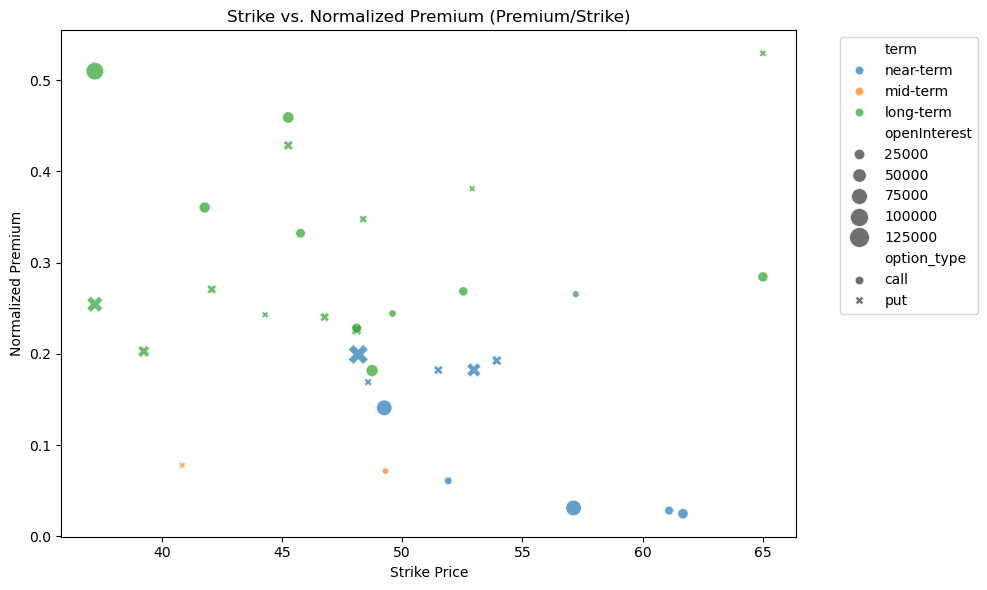

In [8]:
final_df['norm_metric'] = final_df["premium"] / final_df["strike"]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_df, 
    x="strike", 
    y="norm_metric", 
    hue="term", 
    style="option_type", 
    size="openInterest", 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title("Strike vs. Normalized Premium (Premium/Strike)")
plt.xlabel("Strike Price")
plt.ylabel("Normalized Premium")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Generated Summary:
Top Trades to Watch for AAPL Options (Stock Price: $230.49 if available):

Weekly Options (DTE range: <=7):
  Top Calls:
    Strike: $235.00, Expiration: 2025-08-29, Premium: $0.61, Bid/Ask: $0.60/$0.62 (Spread: $0.02), Volume: 25060, Open Interest: 35503, IV: 31.54% (regular cost), Theo Min/Max: $0.00/unbounded
    Strike: $230.00, Expiration: 2025-08-29, Premium: $2.48, Bid/Ask: $2.38/$2.42 (Spread: $0.04), Volume: 54905, Open Interest: 31737, IV: 31.86% (regular cost), Theo Min/Max: $0.49/unbounded
    Strike: $240.00, Expiration: 2025-08-29, Premium: $0.12, Bid/Ask: $0.11/$0.13 (Spread: $0.02), Volume: 8559, Open Interest: 29054, IV: 33.69% (regular cost), Theo Min/Max: $0.00/unbounded
  Calls Premium Range (Top): Min $0.12, Max $2.48
  Top Puts:
    Strike: $215.00, Expiration: 2025-08-29, Premium: $0.10, Bid/Ask: $0.09/$0.10 (Spread: $0.01), Volume: 4257, Open Interest: 46864, IV: 50.00% (regular cost), Theo Min/Max: $0.00/$215.00
    Strike: $220.00, Expiratio

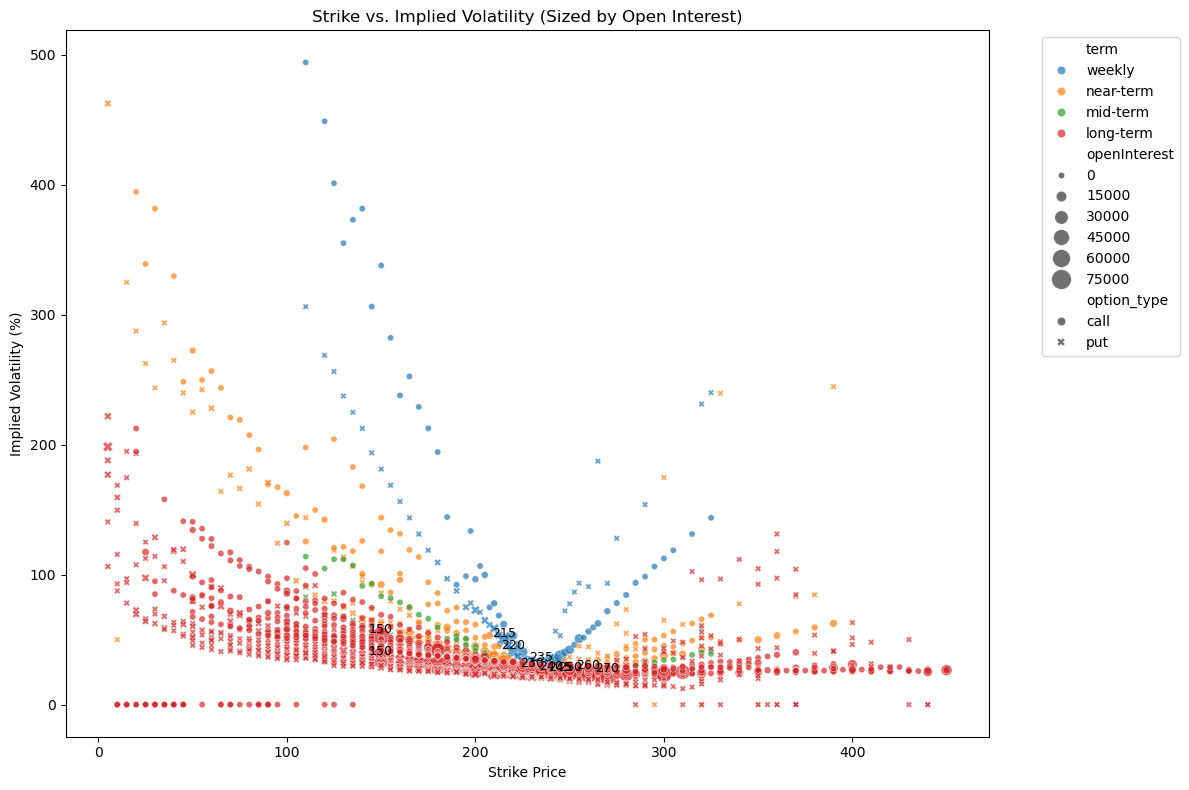

In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests  # Added for Ollama API calls

# Set the current date as per the scenario
CURRENT_DATE = datetime(2025, 8, 27)

# === Step 1: Data Collection ===
def get_option_metrics(ticker_symbol="PLTR"):
    ticker = yf.Ticker(ticker_symbol)
    stock_price = ticker.info.get('currentPrice', None)
    expirations = ticker.options
    contracts = []
    
    # Loop through each expiration date and extract calls and puts
    for exp in expirations:
        opt_chain = ticker.option_chain(exp)
        calls_df = opt_chain.calls
        puts_df = opt_chain.puts

        # Process calls
        for _, row in calls_df.iterrows():
            contract = {
                "symbol": row.get("contractSymbol", ""),
                "strikePrice": row.get("strike", None),
                "expirationDate": exp,  # using expiration string (YYYY-MM-DD)
                "bid": row.get("bid", None),
                "ask": row.get("ask", None),
                "optionType": "call",
                "volume": row.get("volume", 0),
                "openInterest": row.get("openInterest", 0),
                "premium": row.get("lastPrice", None),
                "impliedVol": row.get("impliedVolatility", None) * 100 if row.get("impliedVolatility") else None,  # Convert to percentage
                "stockPrice": stock_price
            }
            contracts.append(contract)
            
        # Process puts
        for _, row in puts_df.iterrows():
            contract = {
                "symbol": row.get("contractSymbol", ""),
                "strikePrice": row.get("strike", None),
                "expirationDate": exp,
                "bid": row.get("bid", None),
                "ask": row.get("ask", None),
                "optionType": "put",
                "volume": row.get("volume", 0),
                "openInterest": row.get("openInterest", 0),
                "premium": row.get("lastPrice", None),
                "impliedVol": row.get("impliedVolatility", None) * 100 if row.get("impliedVolatility") else None,  # Convert to percentage
                "stockPrice": stock_price
            }
            contracts.append(contract)
    
    df = pd.DataFrame(contracts)
    df['spread'] = df['ask'] - df['bid']
    df = df.dropna(subset=['impliedVol'])  # Drop rows without IV
    
    # Calculate theoretical min and max
    df['theo_min'] = 0.0
    df['theo_max'] = 'unbounded'  # Default for calls
    
    calls_mask = df['optionType'] == 'call'
    puts_mask = df['optionType'] == 'put'
    
    # Theo min for calls: max(0, stock - strike)
    df.loc[calls_mask, 'theo_min'] = (df.loc[calls_mask, 'stockPrice'] - df.loc[calls_mask, 'strikePrice']).clip(lower=0)
    
    # Theo min for puts: max(0, strike - stock)
    df.loc[puts_mask, 'theo_min'] = (df.loc[puts_mask, 'strikePrice'] - df.loc[puts_mask, 'stockPrice']).clip(lower=0)
    
    # Theo max for puts: strike (approx, ignoring dividends)
    df.loc[puts_mask, 'theo_max'] = df.loc[puts_mask, 'strikePrice']
    
    # Theo max for calls remains 'unbounded'
    
    return df

# === Utility: Compute Days to Expiration (DTE) and Classify Term ===
def classify_term(expiration_str, today=CURRENT_DATE):
    try:
        exp_date = datetime.strptime(expiration_str, "%Y-%m-%d")
    except Exception:
        return "unknown"
    dte = (exp_date - today).days
    if dte < 0:
        return "expired"
    elif dte == 0:
        return "0DTE"
    elif dte <= 7:
        return "weekly"
    elif dte < 30:
        return "near-term"
    elif 30 <= dte <= 45:
        return "mid-term"
    else:
        return "long-term"

# === Step 2: Generate Enhanced Summary with Dynamic Final Sentiment and Valuation ===
def generate_top_trades_summary(df, ticker_symbol="PLTR"):
    summary_lines = []
    summary_lines.append(f"Top Trades to Watch for {ticker_symbol} Options (Stock Price: ${df['stockPrice'].iloc[0]:.2f} if available):")
    summary_lines.append("")
    
    # Add term classification
    df['term'] = df['expirationDate'].apply(lambda x: classify_term(x))
    df = df[df['term'] != "expired"]  # Remove expired
    
    # Calculate overall mean and std IV for valuation
    mean_iv = df['impliedVol'].mean()
    std_iv = df['impliedVol'].std()
    
    def get_valuation(iv, mean, std):
        if iv > mean + std:
            return "expensive"
        elif iv < mean - std:
            return "cheap"
        else:
            return "regular cost"
    
    # Group by term for detailed listing
    for term in ["0DTE", "weekly", "near-term", "mid-term", "long-term"]:
        term_data = df[df['term'] == term]
        if term_data.empty:
            continue
        dte_range = '0' if term == '0DTE' else '<=7' if term == 'weekly' else '<30' if term == 'near-term' else '30-45' if term == 'mid-term' else '>45'
        summary_lines.append(f"{term.capitalize()} Options (DTE range: {dte_range}):")
        
        # Top 3 Calls by open interest
        calls = term_data[term_data['optionType'] == 'call'].sort_values(by='openInterest', ascending=False).head(3)
        if not calls.empty:
            summary_lines.append("  Top Calls:")
            for _, row in calls.iterrows():
                val = get_valuation(row['impliedVol'], mean_iv, std_iv)
                theo_max_str = row['theo_max'] if isinstance(row['theo_max'], str) else f"${row['theo_max']:.2f}"
                summary_lines.append(
                    f"    Strike: ${row['strikePrice']:.2f}, Expiration: {row['expirationDate']}, "
                    f"Premium: ${row['premium']:.2f}, Bid/Ask: ${row['bid']:.2f}/${row['ask']:.2f} (Spread: ${row['spread']:.2f}), "
                    f"Volume: {row['volume']:.0f}, Open Interest: {row['openInterest']:.0f}, "
                    f"IV: {row['impliedVol']:.2f}% ({val}), "
                    f"Theo Min/Max: ${row['theo_min']:.2f}/{theo_max_str}"
                )
            calls_min_prem = calls['premium'].min()
            calls_max_prem = calls['premium'].max()
            summary_lines.append(f"  Calls Premium Range (Top): Min ${calls_min_prem:.2f}, Max ${calls_max_prem:.2f}")
        else:
            summary_lines.append("  No call options data available.")
        
        # Top 3 Puts by open interest
        puts = term_data[term_data['optionType'] == 'put'].sort_values(by='openInterest', ascending=False).head(3)
        if not puts.empty:
            summary_lines.append("  Top Puts:")
            for _, row in puts.iterrows():
                val = get_valuation(row['impliedVol'], mean_iv, std_iv)
                theo_max_str = row['theo_max'] if isinstance(row['theo_max'], str) else f"${row['theo_max']:.2f}"
                summary_lines.append(
                    f"    Strike: ${row['strikePrice']:.2f}, Expiration: {row['expirationDate']}, "
                    f"Premium: ${row['premium']:.2f}, Bid/Ask: ${row['bid']:.2f}/${row['ask']:.2f} (Spread: ${row['spread']:.2f}), "
                    f"Volume: {row['volume']:.0f}, Open Interest: {row['openInterest']:.0f}, "
                    f"IV: {row['impliedVol']:.2f}% ({val}), "
                    f"Theo Min/Max: ${row['theo_min']:.2f}/{theo_max_str}"
                )
            puts_min_prem = puts['premium'].min()
            puts_max_prem = puts['premium'].max()
            summary_lines.append(f"  Puts Premium Range (Top): Min ${puts_min_prem:.2f}, Max ${puts_max_prem:.2f}")
        else:
            summary_lines.append("  No put options data available.")
        summary_lines.append("")
    
    # Overall Market Sentiment Analysis (using all data)
    total_calls_oi = df[df['optionType'] == "call"]['openInterest'].sum()
    total_puts_oi = df[df['optionType'] == "put"]['openInterest'].sum()
    
    summary_lines.append("Market Sentiment (Overall):")
    summary_lines.append(f"  Total call open interest: {total_calls_oi:.0f}")
    summary_lines.append(f"  Total put open interest: {total_puts_oi:.0f}")
    if total_calls_oi > total_puts_oi * 1.2:
        sentiment = "Strongly bullish sentiment."
    elif total_calls_oi > total_puts_oi:
        sentiment = "Bullish sentiment."
    elif total_puts_oi > total_calls_oi * 1.2:
        sentiment = "Strongly bearish or protective sentiment."
    elif total_puts_oi > total_calls_oi:
        sentiment = "Bearish or protective sentiment."
    else:
        sentiment = "Neutral sentiment."
    summary_lines.append(f"  {sentiment}")
    summary_lines.append("")
    
    # Enhanced Overall Pattern Analysis with Actionable Insights
    if not df.empty:
        avg_call_strike = df[df['optionType'] == "call"]['strikePrice'].mean()
        avg_put_strike = df[df['optionType'] == "put"]['strikePrice'].mean()
        avg_iv = mean_iv
        overall_min_prem = df['premium'].min()
        overall_max_prem = df['premium'].max()
        pattern_analysis = (
            f"The average call strike is approximately ${avg_call_strike:.2f}, while the average put strike is about ${avg_put_strike:.2f}.\n"
            f"Average IV across chain: {avg_iv:.2f}%. This suggests traders are positioning for {'upside' if avg_call_strike > avg_put_strike else 'downside'} moves.\n"
            f"Popular contracts (high OI) are {'cheap' if avg_iv < 50 else 'expensive' if avg_iv > 70 else 'regularly priced'} relative to typical volatility.\n"
            f"Overall Premium Range: Min ${overall_min_prem:.2f}, Max ${overall_max_prem:.2f}"
        )
        summary_lines.append("Overall Pattern Analysis:")
        summary_lines.append(f"  {pattern_analysis}")
    else:
        summary_lines.append("Overall Pattern Analysis: Insufficient data for further insights.")
    
    # Dynamic Final Sentiment per term based on aggregated open interest
    final_sentiments = []
    for term in ["0DTE", "weekly", "near-term", "mid-term", "long-term"]:
        term_data = df[df['term'] == term]
        if term_data.empty:
            continue
        call_oi = term_data[term_data['optionType'] == "call"]['openInterest'].sum()
        put_oi = term_data[term_data['optionType'] == "put"]['openInterest'].sum()
        if call_oi > put_oi * 1.2:
            sentiment = "Strongly Bullish"
        elif call_oi > put_oi:
            sentiment = "Bullish"
        elif put_oi > call_oi * 1.2:
            sentiment = "Strongly Bearish"
        elif put_oi > call_oi:
            sentiment = "Bearish"
        else:
            sentiment = "Neutral"
        final_sentiments.append(f"  {term.capitalize()}: {sentiment}")
    
    summary_lines.append("")
    summary_lines.append("Final Sentiment Summary (Dynamic):")
    summary_lines.extend(final_sentiments)
    
    return "\n".join(summary_lines)

# === New: Analyze Summary with Ollama ===
def analyze_with_ollama(summary_text):
    prompt = f"""
Analyze the following option chain summary for PLTR and pull out the most pertinent that stands out for short-term, mid-term, and long-term trade ideas.

Also include pricing and valuation data of the contracts to know where contracts are popular and relatively cheap, regular cost, or expensive.

Structure your response with sections for Short-Term, Mid-Term, and Long-Term Trade Ideas, including sentiment and disclaimers.

Summary:
{summary_text}
"""
    try:
        response = requests.post('http://localhost:11434/api/generate', json={
            'model': 'llama3.2',  # Adjust if your model tag is different, e.g., 'llama3.2:3b'
            'prompt': prompt,
            'stream': False
        })
        response.raise_for_status()
        return response.json().get('response', 'Error: No response from Ollama.')
    except Exception as e:
        return f"Error calling Ollama: {str(e)}. Ensure Ollama is running locally on http://localhost:11434."

# === Step 3: Prepare Data for Visualization ===
def prepare_visualization_df(df):
    final_df = df.rename(columns={
        "strikePrice": "strike",
        "optionType": "option_type",
        "impliedVol": "iv"
    }).copy()
    final_df["norm_score"] = final_df["premium"]  # Or use IV for y-axis
    return final_df

# === Step 4: Visualize the Data with Top 3 Annotations per Term ===
def visualize_data(final_df):
    upper_cutoff = final_df["norm_score"].quantile(0.99)
    filtered_df = final_df[final_df["norm_score"] < upper_cutoff]
    
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        data=filtered_df,
        x="strike",
        y="iv",  # Changed to IV for better insight into valuation
        hue="term",
        style="option_type",
        size="openInterest",
        alpha=0.7,
        sizes=(20, 200)
    )
    plt.title("Strike vs. Implied Volatility (Sized by Open Interest)")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Annotate top 3 trades (by open interest) for each term group with their strike price
    for term, group in filtered_df.groupby("term"):
        top3 = group.sort_values(by="openInterest", ascending=False).head(3)
        for _, row in top3.iterrows():
            ax.text(
                row["strike"], row["iv"],
                f'{row["strike"]:.0f}',
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=9,
                color='black'
            )
    
    plt.tight_layout()
    plt.show()

# === Main Execution Block ===
if __name__ == "__main__":
    stock = "AAPL"
    df = get_option_metrics(stock)
    summary_text = generate_top_trades_summary(df, stock)
    print("Generated Summary:")
    print(summary_text)
    
    # Analyze with Ollama
    ollama_analysis = analyze_with_ollama(summary_text)
    print("\nOllama Analysis:")
    print(ollama_analysis)
    
    final_df = prepare_visualization_df(df)
    visualize_data(final_df)